In [1]:
"""
@author Rahul Gupta
"""

import string
import re
import tweepy
import json
import twitterClient

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon

from colorama import Fore, Style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

C:\Users\user\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [4]:
class TwitterProcessing:
    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords

    def process(self, text):
        text = text.lower()
        tokens = self.tokeniser.tokenize(text)
        tokensStripped = [tok.strip() for tok in tokens]
        regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
        regexHttp = re.compile("^http")

        return [tok for tok in tokensStripped if tok not in self.lStopwords and
                regexDigit.match(tok) == None and regexHttp.match(tok) == None]

In [5]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    posNum = len([tok for tok in lTokens if tok in setPosWords])
    negNum = len([tok for tok in lTokens if tok in setNegWords])
    return posNum - negNum

def countWordSentimentAnalysis(setPosWords, setNegWords, tweets, tweetProcessor):
    # Get tweet and remove duplicates
    tweet_text = list(set([tweet['text'] for tweet in tweets]))
    lSentiment = []
    for tweet in tweet_text:
        try:
            tokens = tweetProcessor.process(tweet)
            sentiment = computeSentiment(tokens, setPosWords, setNegWords)
            lSentiment.append([tweet, sentiment])
        except KeyError as e:
            pass
    return lSentiment

def vaderSentimentAnalysis(tweets, tweetProcessor):
    sentAnalyser = SentimentIntensityAnalyzer()
    lSentiment = []
    for tweet in tweets:
        try:
            tweetText = tweet['text']
            tweetDate = tweet['created_at']

            lTokens = tweetProcessor.process(tweetText)
            dSentimentScores = sentAnalyser.polarity_scores(' '.join(lTokens))
            lSentiment.append([pd.to_datetime(tweetDate), tweetText, dSentimentScores['compound']])

        except KeyError as e:
            pass
    return lSentiment

In [6]:
def save_tweets(query, max_tweets, output_file):
    api = twitterClient.twitter_client()
    tweets = []

    for tweet in tweepy.Cursor(api.search, q=query, lang="en").items(max_tweets):
        tweets.append(tweet._json)

    with open(output_file, 'w') as f:
        json.dump(tweets, f)

In [7]:
query = 'streaming service OR streaming movies OR streaming series'
max_tweets = 200
output_file = 'streaming_service.json'

# save_tweets(query, max_tweets, output_file)

Don't read the json file again and again

In [8]:
with open(output_file, 'r') as f:
    for line in f:
        tweets = json.loads(line)

In [9]:
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`','’', '‘']

tweetProcessor = TwitterProcessing(tweetTokenizer, lStopwords)

PosWords = opinion_lexicon.positive()
NegWords = opinion_lexicon.negative()

## Sentiment values

In [10]:
lSentiment = countWordSentimentAnalysis(PosWords, NegWords, tweets, tweetProcessor)

In [11]:
streaming_tweets = pd.DataFrame(lSentiment)
streaming_tweets.columns = ['text','Sentiment']

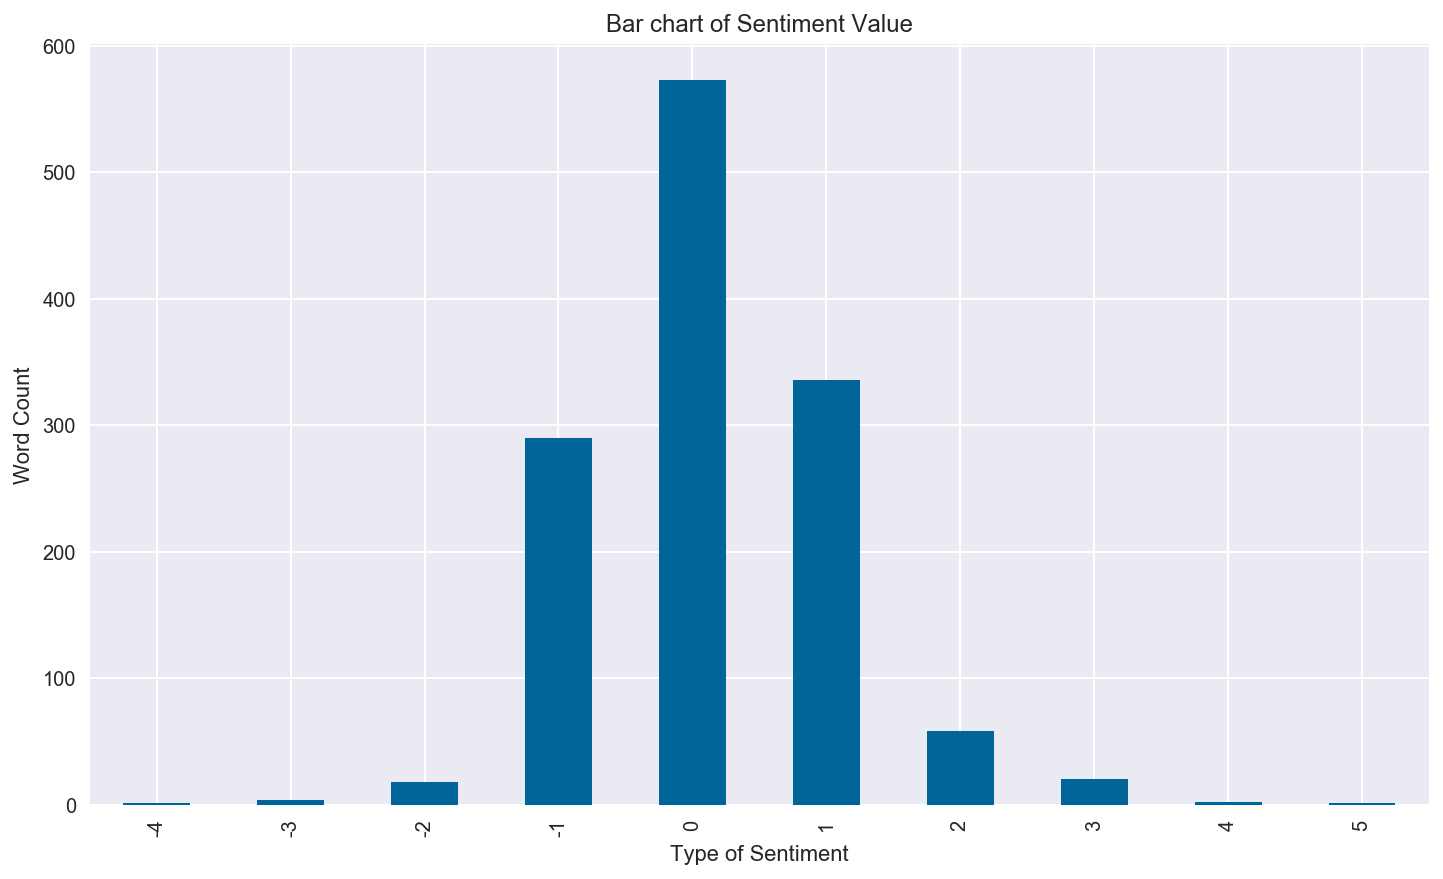

In [12]:
plt.rcParams["figure.figsize"] = (12,7)
pd.value_counts(streaming_tweets['Sentiment'].values, 
                sort=True, ascending=False).sort_index().plot(kind='bar', color='#006699')
plt.ylabel('Word Count')
plt.xlabel('Type of Sentiment')
plt.title('Bar chart of Sentiment Value')
plt.legend().set_visible(False)
plt.show()

* From the chart We can see most of the tweets for Media Streaming are Neutral

* Negative Tweets are Higher than the positive tweets

Next we can analyze some most positive and negative tweets

In [13]:
conditions = [
    (streaming_tweets['Sentiment'] > 0),
    (streaming_tweets['Sentiment'] < 0),
    (streaming_tweets['Sentiment'] == 0),]
choices = ['Positive', 'Negative', 'Neutral']
streaming_tweets['sentiment_type'] = np.select(conditions, choices)

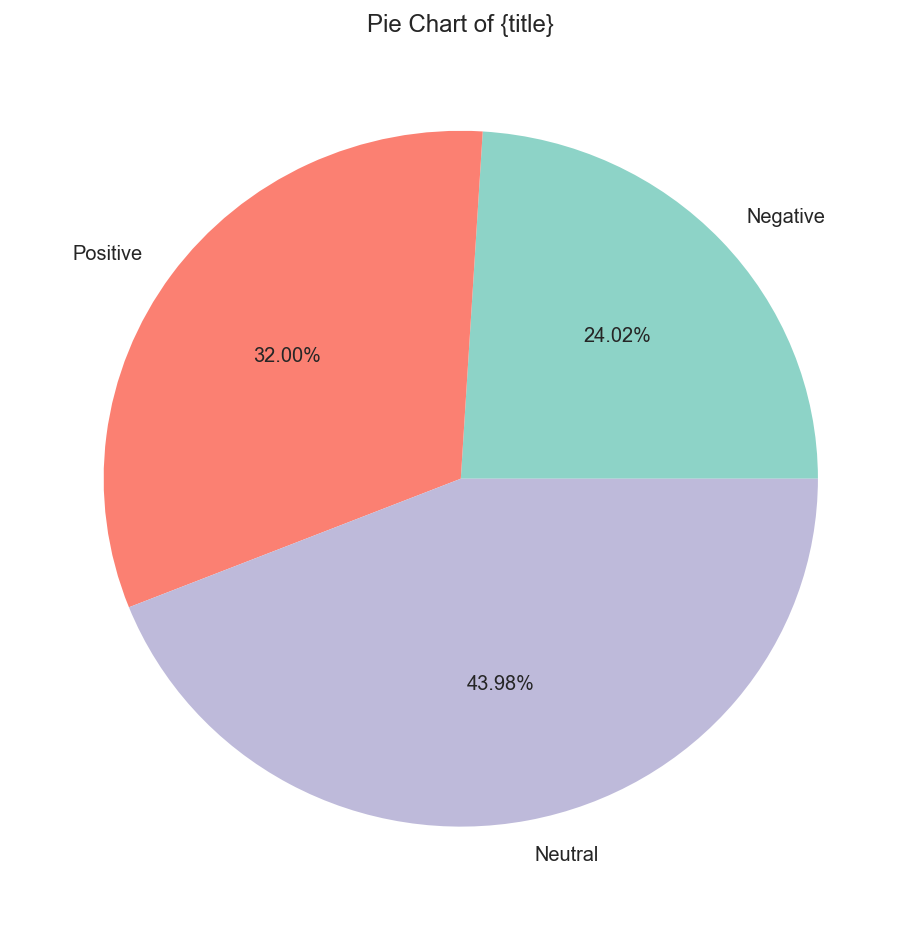

In [14]:
def make_pie_chart(data, column, title = 'Pie chart'):
    plt.rcParams["figure.figsize"] = (8,8)
    color_brewer_set2 = ["#8DD3C7","#FB8072","#BEBADA","#FFFFB3",
                         "#80B1D3","#FDB462","#B3DE69","#FCCDE5", ]

    pd.value_counts(data[column].values, sort=True, ascending=True). \
    plot(kind='pie',autopct='%1.2f%%', colors=color_brewer_set2)
    plt.title('Pie Chart of {title}')
    plt.xlabel('')
    plt.ylabel('')
make_pie_chart(streaming_tweets,'sentiment_type','Sentiments')
plt.show()

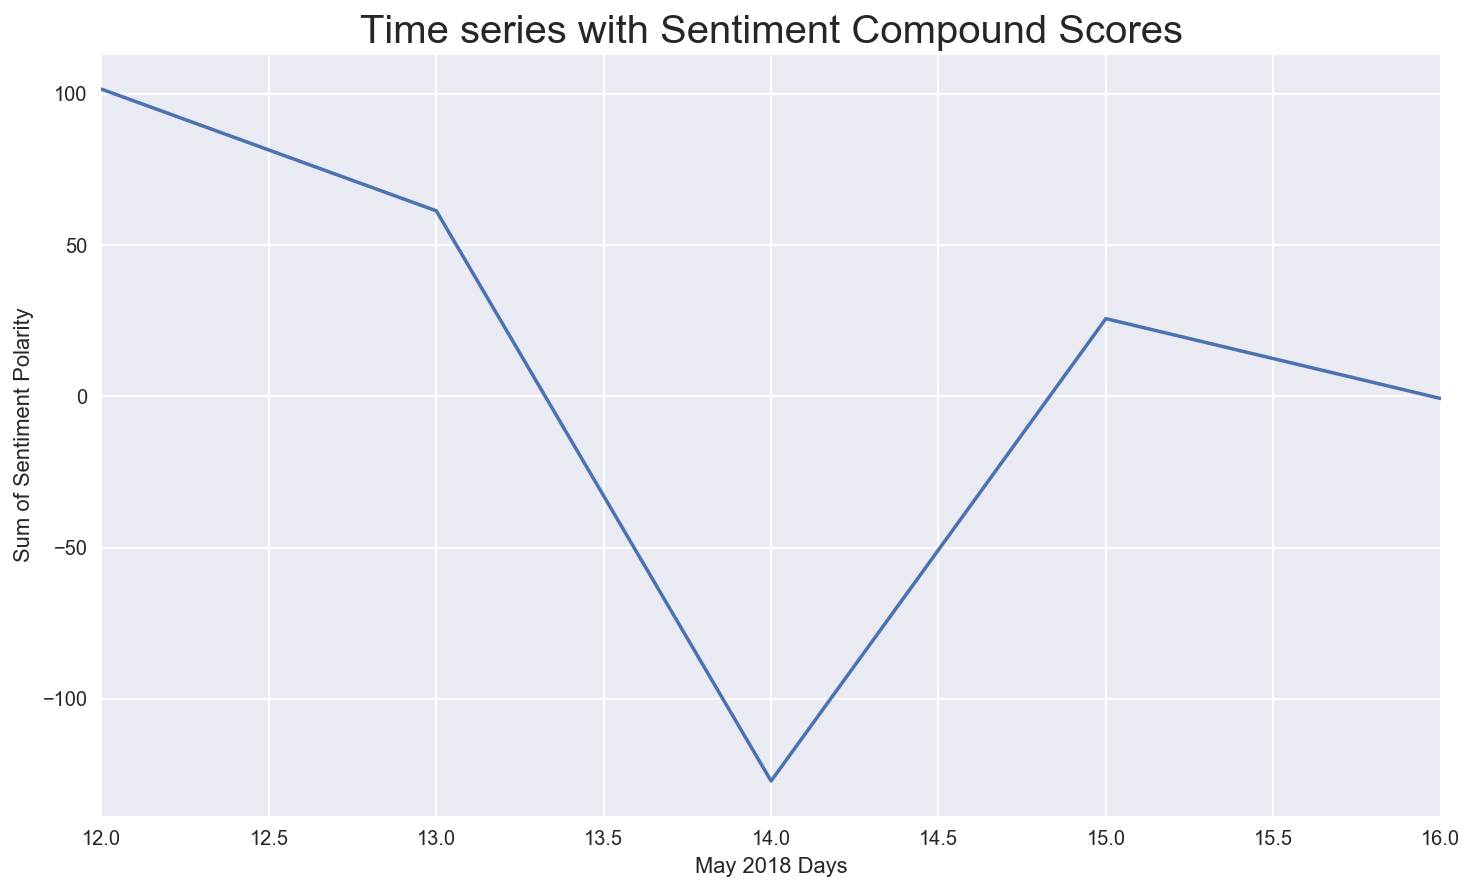

In [15]:
sentiment = vaderSentimentAnalysis(tweets, tweetProcessor)
streaming_compound = pd.DataFrame(sentiment)
streaming_compound.columns = ['Timestamp', 'text','compound']
times = pd.DatetimeIndex(streaming_compound['Timestamp'])
plt.rcParams["figure.figsize"] = (12,7)
streaming_compound.groupby(times.day).compound.sum().plot()
plt.title('Time series with Sentiment Compound Scores', fontsize=20)
plt.xlabel('May 2018 Days')
plt.ylabel('Sum of Sentiment Polarity')
plt.show()

We have many negative tweets on 14-May-2018. This need to be studied as it affected the whole data set polarity

## Key words analysis

**Most Used Keywords**

In [16]:
from collections import Counter
def get_frequent_keywords(tweets, tweetProcessor, limit=15):
    tweet_text = set([tweet['text'] for tweet in tweets])
    freq_counter = Counter()
    for tweet in tweet_text:
        tokens = tweetProcessor.process(tweet)
        freq_counter.update(tokens)
    return freq_counter.most_common(limit)

In [17]:
freq = get_frequent_keywords(tweets, tweetProcessor)
freq_df = pd.DataFrame(freq, columns=['word','count'])
freq_df.sort_values('count', ascending=False, inplace=True)

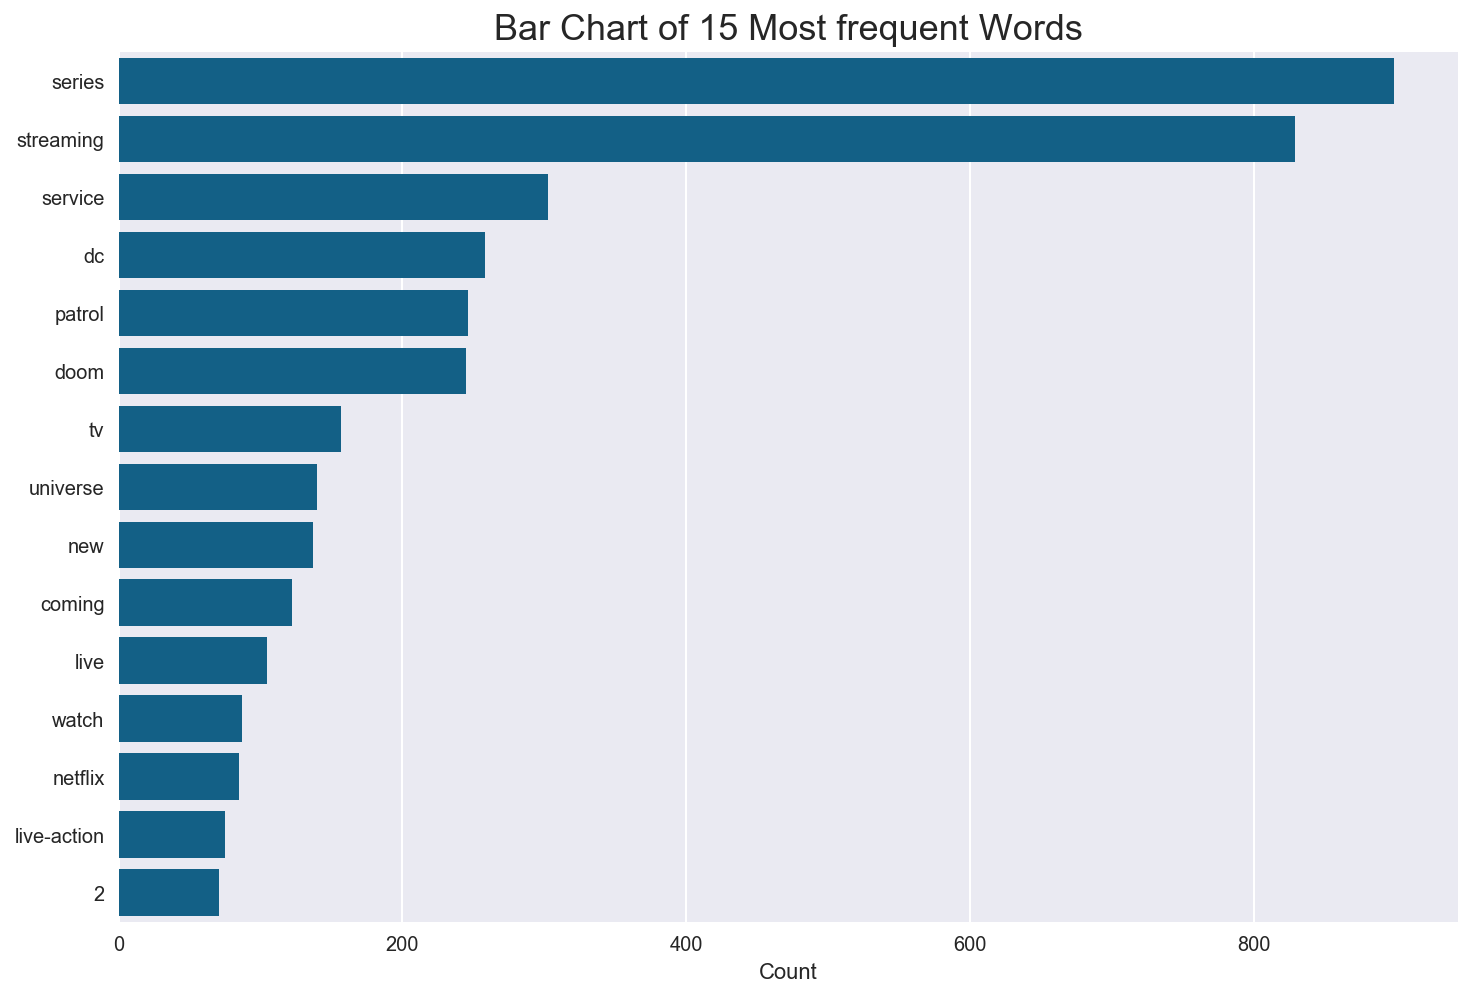

In [18]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.barplot(x='count', y='word', data=freq_df, color='#006699')
plt.title('Bar Chart of 15 Most frequent Words', fontsize=18)
plt.ylabel('')
plt.xlabel('Count')
plt.show()

## Hashtag frequency

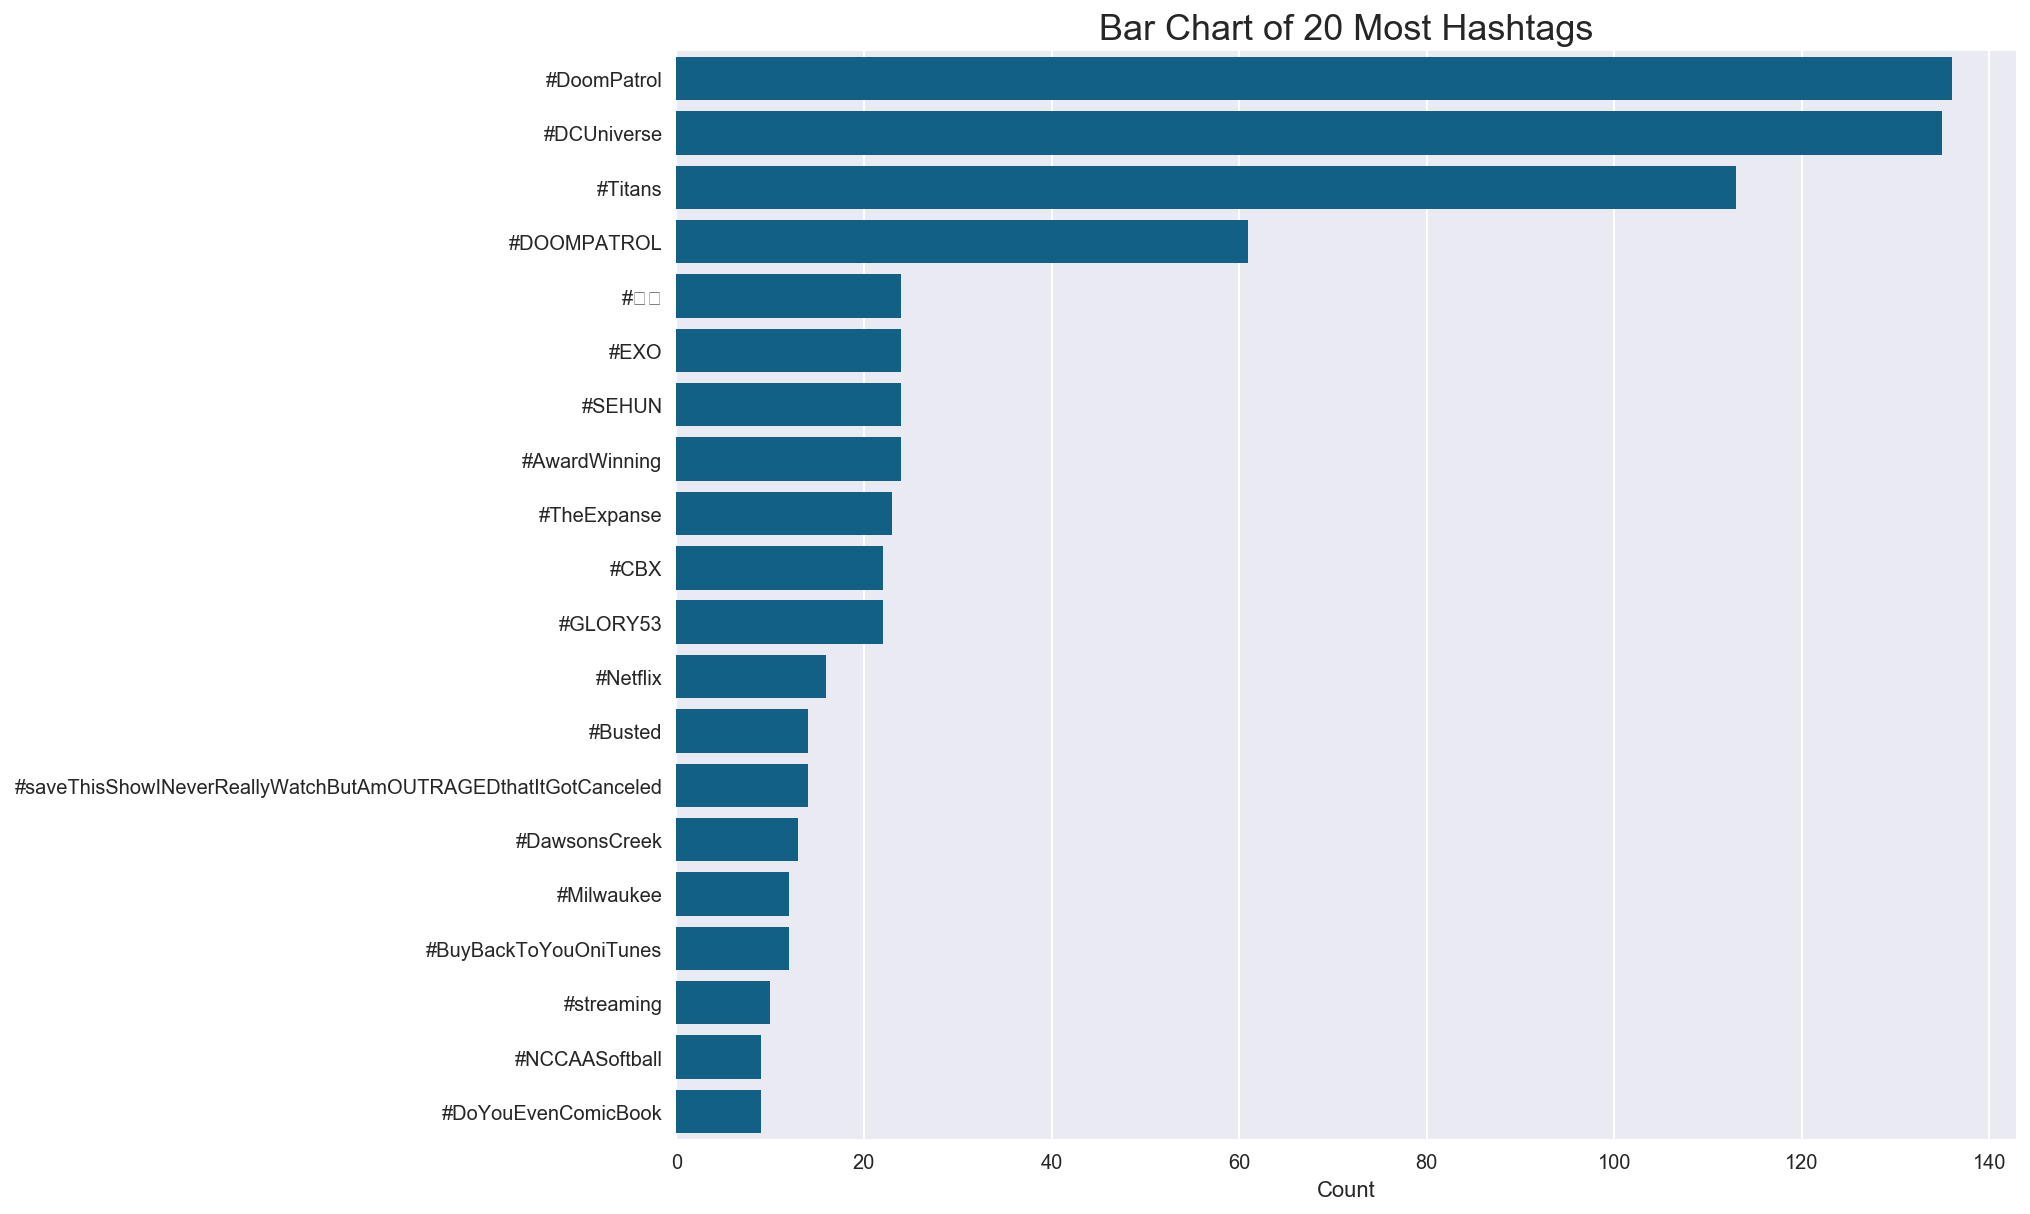

In [19]:
hashtag = []
for tweet in tweets:
    if tweet['entities']['hashtags'] != []:
        for i in tweet['entities']['hashtags']:
            hashtag.append('#' + i['text'])

freq_counter = Counter()
freq_counter.update(hashtag)
freq_df = pd.DataFrame(freq_counter.most_common(20), columns=['word','count'])
freq_df

plt.rcParams['figure.figsize'] = (12, 10)
sns.barplot(x='count', y='word', data=freq_df, color='#006699')
plt.title('Bar Chart of 20 Most Hashtags', fontsize=18)
plt.ylabel('')
plt.xlabel('Count')
plt.show()

### Top Negative Tweets

In [20]:
streaming_tweets.sort_values('Sentiment', inplace=True)
top_negative = list(streaming_tweets.iloc[0:5]['text'])
for text in top_negative:
    print(text)

Any series: you want garbage? You want fucking garbage? You want this bastard we literally pulled out of our garbag… https://t.co/pl0rsz6pFZ
It's funny that complex media (streaming TV series, video games) know exactly which parts killed user interest, but… https://t.co/aod6nvBKlp
Fear the Walking Dead is a good show, but they (the characters) made idiot mistakes all the time. I guess it make t… https://t.co/iz6PnzvBcH
Netflix’s Dark is hard to watch, and impossible to stop watching https://t.co/1bzvUDKZPF via @Verge
Current planned games for streaming:
Far Cry 4 / Far Cry 5
Current planned games for Youtube:
Dark Souls series
Und… https://t.co/PjFjuPcmaY


In [122]:
"""
@author Megha Mohan
"""
import praw
import time
import random
import sys
import csv
import math
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from IPython.display import display 
from IPython.display import clear_output
from pprint import pprint
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [98]:
reddit = praw.Reddit(client_id='PiURtsGqnsmLEA',
                     client_secret='JodQ8pfG4OJ1TiYQPvkjcCAlG6s',
                     user_agent='SocialMedia')

In [99]:

for submission in reddit.subreddit('series').new(limit=None):
    headlines.add(submission.title)
    clear_output()
    print(len(headlines))

2799


In [100]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headlines'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': -0.5994,
  'headlines': 'Hamara Media Sri Devi Aur Sham ( Sri Devi Death & Our Media ) Urdu/Hindi',
  'neg': 0.262,
  'neu': 0.738,
  'pos': 0.0},
 {'compound': 0.0,
  'headlines': 'President Trump donates his first quarter salary to the VA',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.3089,
  'headlines': "How do I tell someone I don't want to see them in my streams anymore without being "
               'an awful person?',
  'neg': 0.062,
  'neu': 0.812,
  'pos': 0.126}]


In [101]:
df = pd.DataFrame.from_records(results)
df.head()

,compound,headlines,neg,neu,pos
0,-0.5994,Hamara Media Sri Devi Aur Sham ( Sri Devi Deat...,0.262,0.738,0.000
1,0.0000,President Trump donates his first quarter sala...,0.000,1.000,0.000
2,0.3089,How do I tell someone I don't want to see them...,0.062,0.812,0.126
3,0.0000,Democrats and Pundits Out of Touch with New Me...,0.000,1.000,0.000
4,0.0000,"1,000 ‘domestic terrorists’ are being investig...",0.000,1.000,0.000


In [102]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,compound,headlines,neg,neu,pos,label
0,-0.5994,Hamara Media Sri Devi Aur Sham ( Sri Devi Deat...,0.262,0.738,0.000,-1
1,0.0000,President Trump donates his first quarter sala...,0.000,1.000,0.000,0
2,0.3089,How do I tell someone I don't want to see them...,0.062,0.812,0.126,1
3,0.0000,Democrats and Pundits Out of Touch with New Me...,0.000,1.000,0.000,0
4,0.0000,"1,000 ‘domestic terrorists’ are being investig...",0.000,1.000,0.000,0


In [103]:
df2 = df[['headlines','label']]

In [104]:
df2.to_csv('reddit_headlines_labels.csv', mode='a', encoding='utf-8', index=False)

In [105]:
df.label.value_counts()

 0    1385
-1     734
 1     680
Name: label, dtype: int64

In [106]:
print("Positive headlines:\n")
pprint(list(df[df['label'] == 1].headlines)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].headlines)[:5], width=200)


Positive headlines:

["How do I tell someone I don't want to see them in my streams anymore without being an awful person?",
 'Republicans want Big Government, too. They just want it to help fewer people.',
 'This North Texas company doesn’t just like Trump’s tariffs – it wants more of them | Trade',
 'Looking for your support!',
 "Trump vows to protect children after 'horrific' Texas school shooting"]

Negative headlines:

['Hamara Media Sri Devi Aur Sham ( Sri Devi Death & Our Media ) Urdu/Hindi',
 'Battled my way to Legend Rank in Hearthstone ...',
 'Torture Black-Site Chief Gina Haspel Becomes Trump’s New CIA Director',
 '...notice the hysterical tone that Bill Binney’s appearance on the scene has provoked from the President’s enemies',
 'Did Trump Jr. call the blocked number, or vice versa?']


In [107]:
df.label.value_counts(normalize=True) * 100

 0    49.481958
-1    26.223651
 1    24.294391
Name: label, dtype: float64

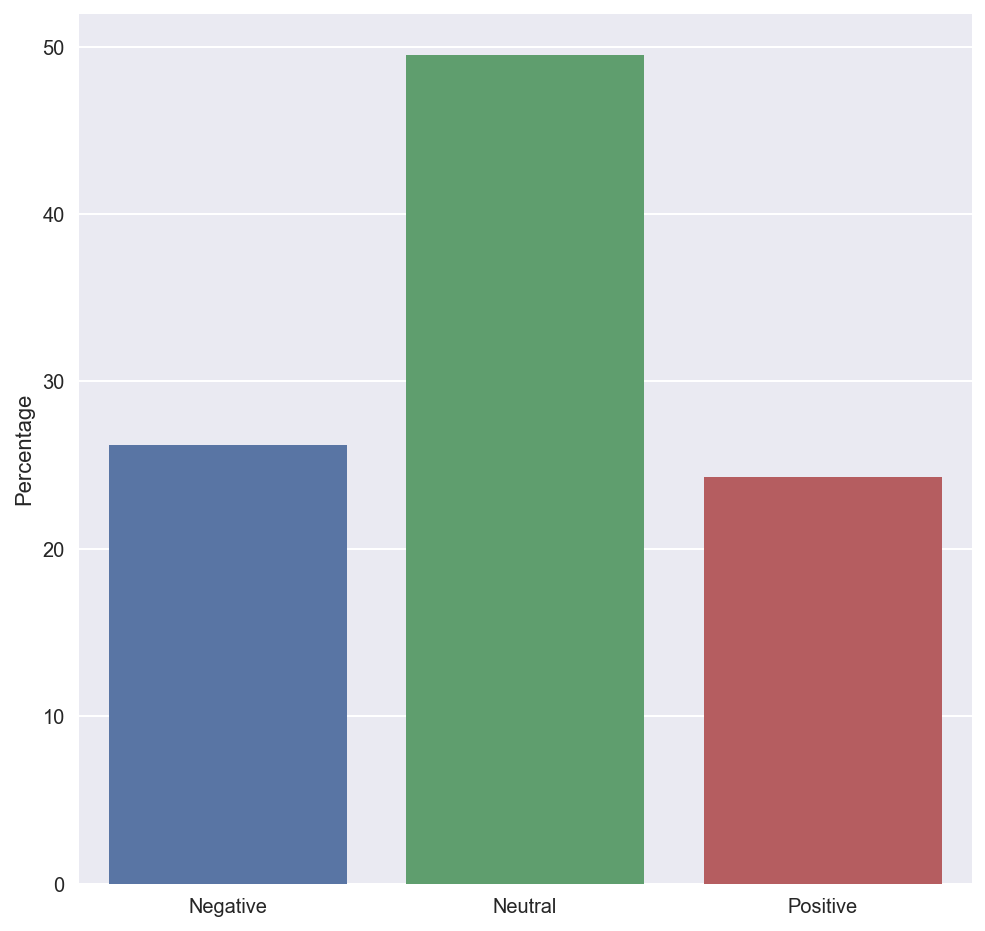

In [108]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [94]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

In [109]:
example = "This is an example sentence! However, it isn't a very informative one"
print(word_tokenize(example, language='english'))

['This', 'is', 'an', 'example', 'sentence', '!', 'However', ',', 'it', 'is', "n't", 'a', 'very', 'informative', 'one']


In [110]:
tokenizer = RegexpTokenizer(r'\w+')
print(tokenizer.tokenize(example))

['This', 'is', 'an', 'example', 'sentence', 'However', 'it', 'isn', 't', 'a', 'very', 'informative', 'one']


In [111]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [112]:
def process_text(headlines):
    tokens = []
    for line in headlines:
        line = line.lower()
        toks = tokenizer.tokenize(line)
        toks = [t for t in toks if t not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [114]:
pos_lines = list(df[df.label == 1].headlines)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('streaming', 82),
 ('trump', 76),
 ('help', 70),
 ('stream', 69),
 ('come', 59),
 ('new', 50),
 ('playing', 45),
 ('fortnite', 38),
 ('media', 31),
 ('join', 29),
 ('play', 29),
 ('support', 27),
 ('live', 27),
 ('twitch', 26),
 ('streamer', 25),
 ('2', 24),
 ('need', 24),
 ('says', 22),
 ('like', 20),
 ('free', 20)]

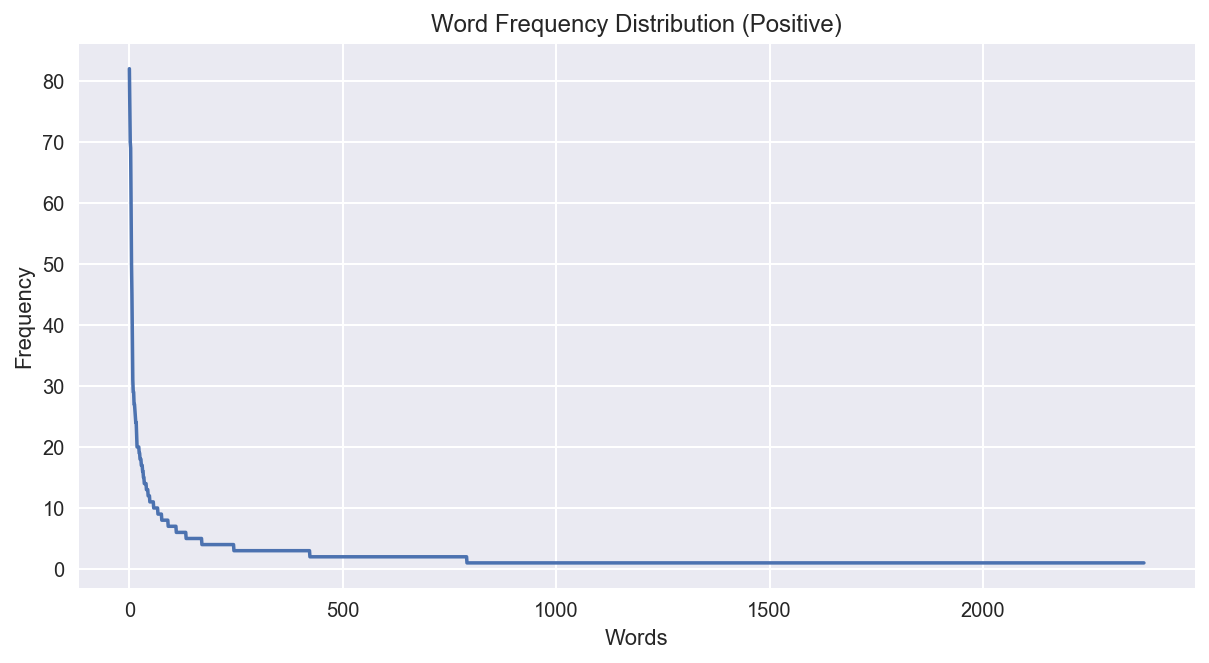

In [115]:

y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

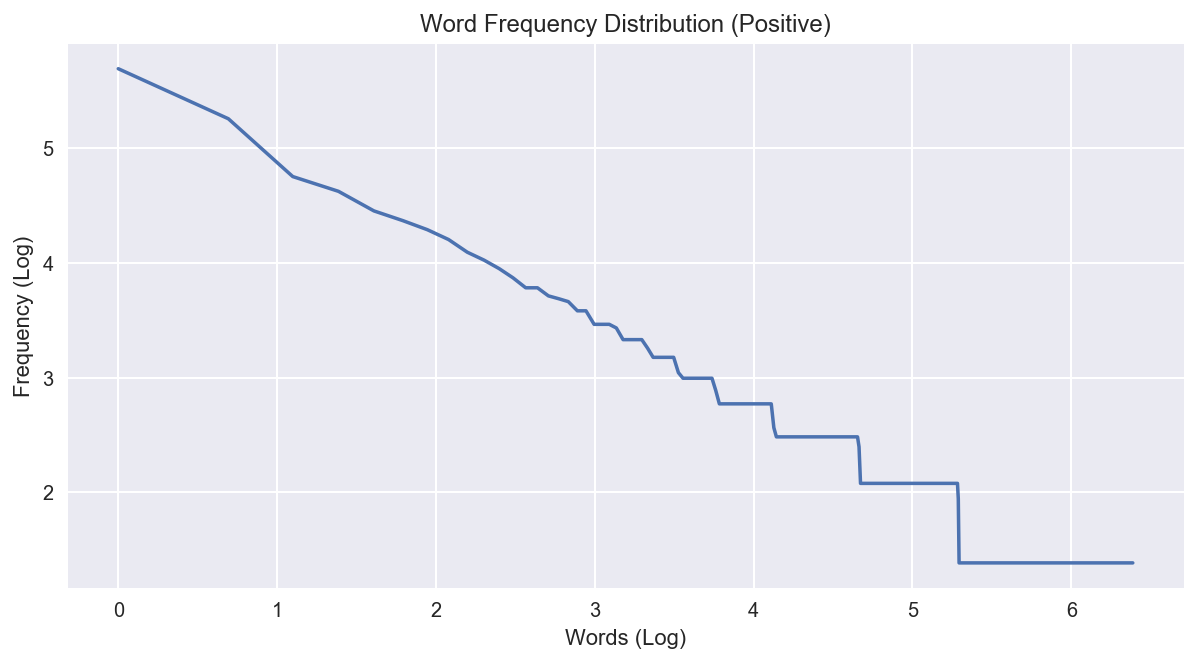

In [116]:
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

In [118]:
neg_lines = list(df2[df2.label == -1].headlines)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('trump', 147),
 ('media', 106),
 ('news', 61),
 ('new', 49),
 ('us', 46),
 ('war', 44),
 ('russia', 38),
 ('fake', 34),
 ('russian', 33),
 ('house', 26),
 ('streaming', 26),
 ('syria', 23),
 ('times', 21),
 ('bill', 20),
 ('says', 18),
 ('propaganda', 18),
 ('mainstream', 18),
 ('gop', 17),
 ('mueller', 16),
 ('political', 16)]

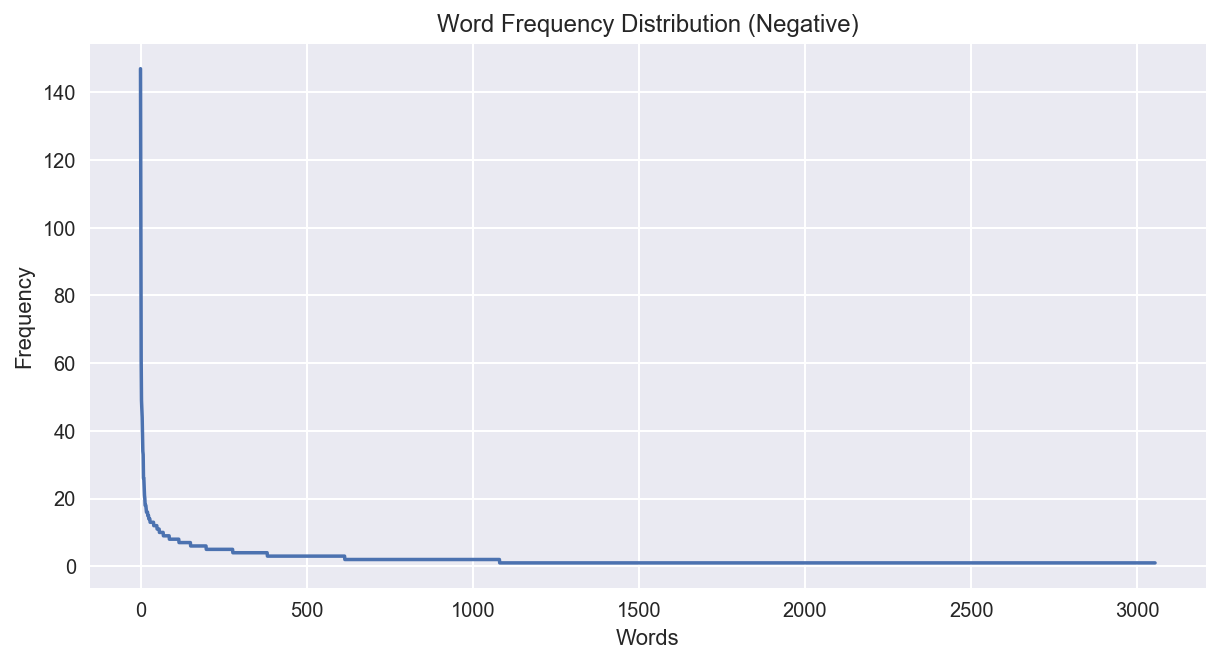

In [119]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

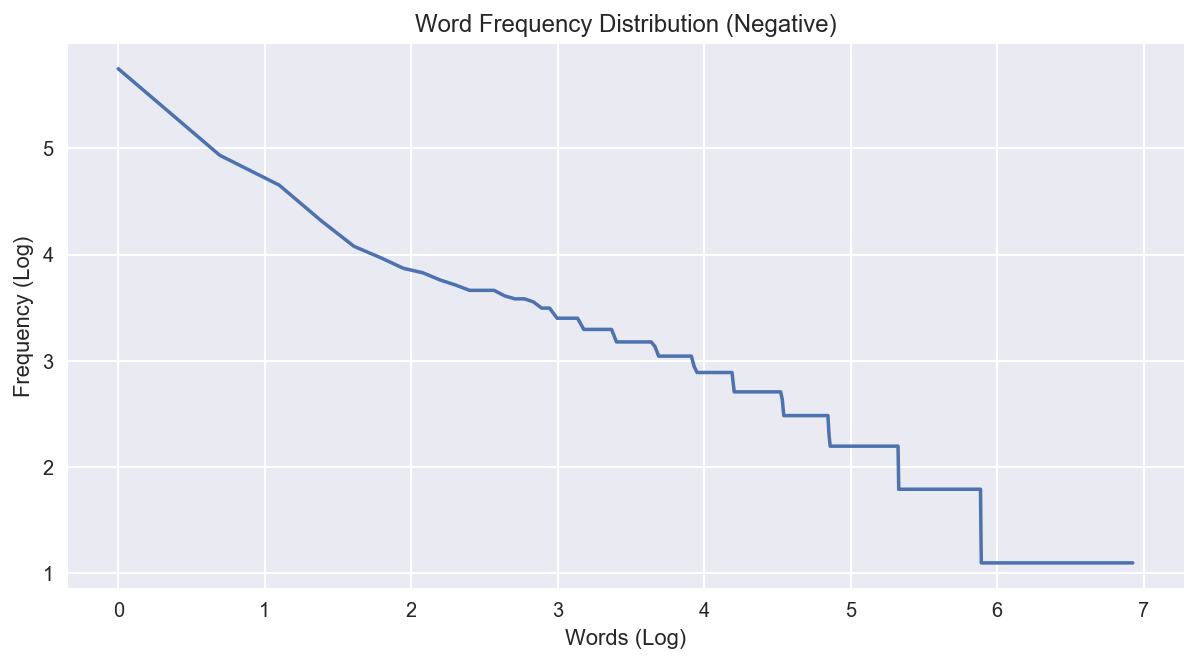

In [120]:

y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()

In [121]:
def run_sentiment_analysis():
    '''Reads the posts and comments and performs the analysis.'''
    sia = SIA()